# Filtering candidate labels
In this notebook, we will analyze the labels created in the candidate_label_creation notebook and then use a simple rule-based filter to remove labels that are trivially either unrepresentative or indistinctive.

We'll look at each type of label separately.

### Pre-requisite steps to run this notebook
1. You need to run the candidate_label_creation notebook before this notebook.

In [1]:
import pandas as pd
import os
import subprocess
import matplotlib.pyplot as plt
import numpy as np
from utility import rename_cols_and_overwrite_id
from utility import run_command

### Parameters
**Required**  
*work_dir*: path to work_dir that was specified in candidate_label_creation notebook. This should contain a folder called label_creation with files created by the label creation notebook which we will filter in this notebook.  
*store_dir*: path to folder containing the sqlite3.db file that we will use for our queries. We will reuse an existing file if there is one in this folder. Otherwise we will create a new one.

In [2]:
# **REQUIRED**
work_dir = "../../Q154/profiler_work"
store_dir = "../../Q154"

### Process params / set up variables

In [3]:
# Ensure paths are absolute
work_dir = os.path.abspath(work_dir)
store_dir = os.path.abspath(store_dir)

label_creation_dir = "{}/label_creation".format(work_dir)
    
# Create output directory
output_dir = "{}/candidate_filter".format(work_dir)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# adding some environment variables we'll be using frequently
os.environ['STORE'] = "{}/wikidata.sqlite3.db".format(store_dir)
os.environ['OUT'] = output_dir
os.environ['IN'] = label_creation_dir
os.environ['kgtk'] = "kgtk" # Need to do this for kgtk to be recognized as a command when passing it through a subprocess call

helper for doing filtering and visualizing the results

In [103]:
def filter_by_support_and_plot(support_file, filtered_out_file, filtered_file, alpha = .1):
    df = pd.read_csv(support_file, delimiter = '\t')
#     df = df.loc[df.loc[:,"node1"] == "Q44"]
    
    supports = df.loc[:,"support"]
    
    mask_filtered_out = ((supports < alpha) | (supports > (1 - alpha)))
    filtered_out = supports.loc[mask_filtered_out]
    not_filtered_out = supports.loc[~mask_filtered_out]
    
    print("Number of labels filtered out: {} / {} ({:.2f}%)".format(len(filtered_out), len(supports), 100*(len(filtered_out) / len(supports))))
    
    bins = np.arange(0,1.01,.02)
    plt.hist(filtered_out, label = "filtered out", bins = bins)
    plt.hist(not_filtered_out, label = "not filtered out", bins = bins)
    
    plt.title("Distribution of Label Supports")
    plt.legend()
    plt.show()
    
    df_filtered_out = df.loc[mask_filtered_out]
    df_not_filtered_out = df.loc[~mask_filtered_out]
    
    df_filtered_out.to_csv(filtered_out_file, sep='\t', index = False)
    df_not_filtered_out.to_csv(filtered_file, sep='\t', index = False)

## AVL - string labels

Adding support column, filtering based on support, sending filtered labels to files, and plotting a distribution of supports

Number of labels filtered out: 8027 / 11090 (72.38%)


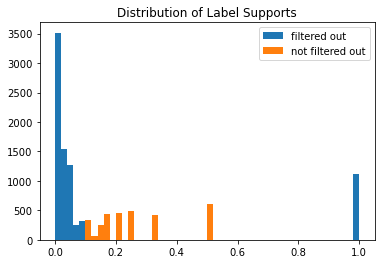

In [74]:
if not os.path.isfile("{}/candidate_labels_avl_string.tsv".format(label_creation_dir)):
    print("No string labels file found, skipping this step.")
else:
    # perform query
    command = "$kgtk query -i $IN/entity_counts_per_type.tsv -i $IN/candidate_labels_avl_string.tsv \
               -o $OUT/candidate_labels_avl_string_supports.tsv \
               --graph-cache $STORE \
               --match 'candidate: (type)-[l1 {label:prop, positives:pos, property_label:lab}]->(val), counts_per_type: (type)-[]->(count)' \
               --return 'type as type, prop as prop, val as val, lab as prop_label, pos as positives, kgtk_quantity_number_float(pos)/kgtk_quantity_number(count) as support, \"_\" as id' \
               --order-by 'kgtk_quantity_number_float(pos)/kgtk_quantity_number(count)'"
    run_command(command)
    # reformat columns to be in KGTK format
    rename_cols_and_overwrite_id("$OUT/candidate_labels_avl_string_supports", ".tsv", "type prop val", "node1 label node2")
    # Filter labels based on support value, send to files, and plot distribution of label support.
    supports_file = "{}/candidate_labels_avl_string_supports.tsv".format(output_dir)
    filtered_out_file = "{}/candidate_labels_avl_string_filtered_out.tsv".format(output_dir)
    filtered_file = "{}/candidate_labels_avl_string_filtered.tsv".format(output_dir)
    filter_by_support_and_plot(supports_file, filtered_out_file, filtered_file)

## AVL - time.year labels

Adding support column

In [75]:
!kgtk query -i $IN/entity_counts_per_type.tsv -i $IN/candidate_labels_avl_time.year.tsv \
-o $OUT/candidate_labels_avl_time.year_supports.tsv \
--graph-cache $STORE \
--match 'candidate: (type)-[l1 {label:prop, positives:pos, property_label:lab}]->(val), counts_per_type: (type)-[]->(count)' \
--return 'type as type, prop as prop, val as val, lab as prop_label, pos as positives, kgtk_quantity_number_float(pos)/kgtk_quantity_number(count) as support, "_" as id' \
--order-by 'kgtk_quantity_number_float(pos)/kgtk_quantity_number(count)'

In [76]:
rename_cols_and_overwrite_id("$OUT/candidate_labels_avl_time.year_supports", ".tsv", "type prop val", "node1 label node2")

Filter labels based on support value, send to files, and plot distribution of label support.

Number of labels filtered out: 1589 / 2184 (72.76%)


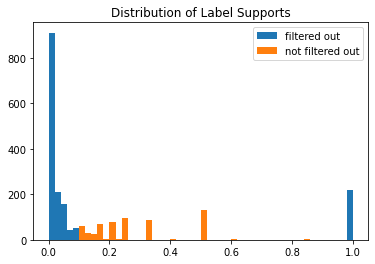

In [77]:
supports_file = "{}/candidate_labels_avl_time.year_supports.tsv".format(output_dir)
filtered_out_file = "{}/candidate_labels_avl_time.year_filtered_out.tsv".format(output_dir)
filtered_file = "{}/candidate_labels_avl_time.year_filtered.tsv".format(output_dir)
filter_by_support_and_plot(supports_file, filtered_out_file, filtered_file)

## AVL - quantity labels

Adding support column

In [78]:
!kgtk query -i $IN/entity_counts_per_type.tsv -i $IN/candidate_labels_avl_quantity.tsv \
-o $OUT/candidate_labels_avl_quantity_supports.tsv \
--graph-cache $STORE \
--match 'candidate: (type)-[l1 {label:prop, positives:pos, property_label:lab, si_units:si, wd_units:wd}]->(val), counts_per_type: (type)-[]->(count)' \
--return 'type as type, prop as prop, val as val, lab as prop_label, pos as positives, kgtk_quantity_number_float(pos)/kgtk_quantity_number(count) as support, si as si_units, wd as wd_units, "_" as id' \
--order-by 'kgtk_quantity_number_float(pos)/kgtk_quantity_number(count)'

In [79]:
rename_cols_and_overwrite_id("$OUT/candidate_labels_avl_quantity_supports", ".tsv", "type prop val", "node1 label node2")

Filter labels based on support value, send to files, and plot distribution of label support.

Number of labels filtered out: 5334 / 7381 (72.27%)


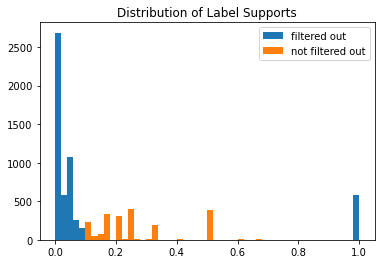

In [80]:
supports_file = "{}/candidate_labels_avl_quantity_supports.tsv".format(output_dir)
filtered_out_file = "{}/candidate_labels_avl_quantity_filtered_out.tsv".format(output_dir)
filtered_file = "{}/candidate_labels_avl_quantity_filtered.tsv".format(output_dir)
filter_by_support_and_plot(supports_file, filtered_out_file, filtered_file)

## RELs

Adding support column

In [104]:
!kgtk query -i $IN/entity_counts_per_type.tsv -i $IN/candidate_labels_rel_item.tsv \
-o $OUT/candidate_labels_rel_item_supports.tsv \
--graph-cache $STORE \
--match 'candidate: (type)-[l1 {label:prop, positives:pos, property_label:lab}]->(val), counts_per_type: (type)-[]->(count)' \
--return 'type as type, prop as prop, val as val, lab as prop_label, pos as positives, kgtk_quantity_number_float(pos)/kgtk_quantity_number(count) as support, "_" as id' \
--order-by 'kgtk_quantity_number_float(pos)/kgtk_quantity_number(count)'

In [105]:
rename_cols_and_overwrite_id("$OUT/candidate_labels_rel_item_supports", ".tsv", "type prop val", "node1 label node2")

Filter labels based on support value, send to files, and plot distribution of label support.

Number of labels filtered out: 95002 / 146750 (64.74%)


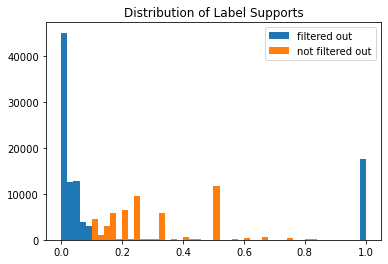

In [106]:
supports_file = "{}/candidate_labels_rel_item_supports.tsv".format(output_dir)
filtered_out_file = "{}/candidate_labels_rel_item_filtered_out.tsv".format(output_dir)
filtered_file = "{}/candidate_labels_rel_item_filtered.tsv".format(output_dir)
filter_by_support_and_plot(supports_file, filtered_out_file, filtered_file)

## RALs - non-bucketed

Adding support column

In [84]:
!kgtk query -i $IN/entity_counts_per_type.tsv -i $IN/candidate_labels_ravl.tsv \
-o $OUT/candidate_labels_ravl_supports.tsv \
--graph-cache $STORE \
--match 'candidate: (type1)-[l1 {label:prop1, prop2:prop2, positives:pos, prop2_label:lab, value:val, si_units:si, wd_units:wd}]->(type2), counts_per_type: (type1)-[]->(count)' \
--return 'type1 as type1, prop1 as prop1, type2 as type2, prop2 as prop2, val as val, lab as prop2_label, pos as positives, kgtk_quantity_number_float(pos)/kgtk_quantity_number(count) as support, si as si_units, wd as wd_units, "_" as id' \
--order-by 'kgtk_quantity_number_float(pos)/kgtk_quantity_number(count)'

In [85]:
rename_cols_and_overwrite_id("$OUT/candidate_labels_ravl_supports", ".tsv", "type1 prop1 type2", "node1 label node2")

Filter labels based on support value, send to files, and plot distribution of label support.

Number of labels filtered out: 538703 / 995859 (54.09%)


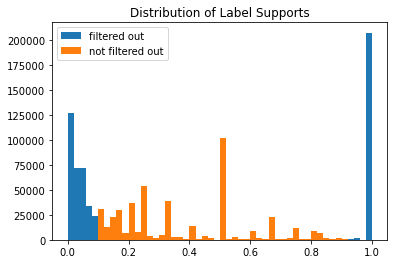

In [86]:
supports_file = "{}/candidate_labels_ravl_supports.tsv".format(output_dir)
filtered_out_file = "{}/candidate_labels_ravl_filtered_out.tsv".format(output_dir)
filtered_file = "{}/candidate_labels_ravl_filtered.tsv".format(output_dir)
filter_by_support_and_plot(supports_file, filtered_out_file, filtered_file)

## RALs - bucketed

Adding support column

In [87]:
!kgtk query -i $IN/entity_counts_per_type.tsv -i $IN/candidate_labels_rail.tsv \
-o $OUT/candidate_labels_rail_supports.tsv \
--graph-cache $STORE \
--match 'candidate: (type1)-[l1 {label:prop1, prop2:prop2, positives:pos, prop2_label:lab, lower_bound:lb, upper_bound:ub, si_units:si, wd_units:wd}]->(type2), counts_per_type: (type1)-[]->(count)' \
--return 'type1 as type1, prop1 as prop1, type2 as type2, prop2 as prop2, lab as prop2_label, lb as lower_bound, ub as upper_bound, pos as positives, kgtk_quantity_number_float(pos)/kgtk_quantity_number(count) as support, si as si_units, wd as wd_units, "_" as id' \
--order-by 'kgtk_quantity_number_float(pos)/kgtk_quantity_number(count)'

In [88]:
rename_cols_and_overwrite_id("$OUT/candidate_labels_rail_supports", ".tsv", "type1 prop1 type2", "node1 label node2")

Filter labels based on support value, send to files, and plot distribution of label support.

Number of labels filtered out: 177985 / 317900 (55.99%)


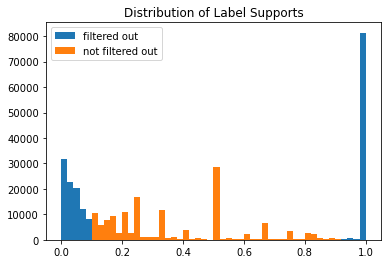

In [89]:
supports_file = "{}/candidate_labels_rail_supports.tsv".format(output_dir)
filtered_out_file = "{}/candidate_labels_rail_filtered_out.tsv".format(output_dir)
filtered_file = "{}/candidate_labels_rail_filtered.tsv".format(output_dir)
filter_by_support_and_plot(supports_file, filtered_out_file, filtered_file)

## AIL - time.year
Note for AILs - we see a big spike at support = 1... Support = 1 will happen if for a given kind of label (distinct <type, property> pair) only a single cluster is formed.

Adding support column

In [90]:
!kgtk query -i $IN/entity_counts_per_type.tsv -i $IN/candidate_labels_ail_time.year.tsv \
-o $OUT/candidate_labels_ail_time.year_supports.tsv \
--graph-cache $STORE \
--match 'candidate: (type)-[l1 {label:prop, upper_bound:ub, positives:pos, property_label:lab}]->(lb), counts_per_type: (type)-[]->(count)' \
--return 'type as type, prop as prop, lb as lower_bound, ub as upper_bound, lab as prop_label, pos as positives, kgtk_quantity_number_float(pos)/kgtk_quantity_number(count) as support, "_" as id' \
--order-by 'kgtk_quantity_number_float(pos)/kgtk_quantity_number(count)'

In [91]:
rename_cols_and_overwrite_id("$OUT/candidate_labels_ail_time.year_supports", ".tsv", "type prop lower_bound", "node1 label node2")

Filter labels based on support value, send to files, and plot distribution of label support.

Number of labels filtered out: 400 / 779 (51.35%)


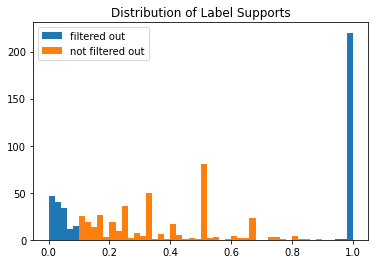

In [92]:
supports_file = "{}/candidate_labels_ail_time.year_supports.tsv".format(output_dir)
filtered_out_file = "{}/candidate_labels_ail_time.year_filtered_out.tsv".format(output_dir)
filtered_file = "{}/candidate_labels_ail_time.year_filtered.tsv".format(output_dir)
filter_by_support_and_plot(supports_file, filtered_out_file, filtered_file)

## AIL - Quantity
Note for AILs - we see a big spike at support = 1... Support = 1 will happen if for a given kind of label (distinct <type, property, units>) only a single cluster is formed.

Adding support column

In [93]:
!kgtk query -i $IN/entity_counts_per_type.tsv -i $IN/candidate_labels_ail_quantity.tsv \
-o $OUT/candidate_labels_ail_quantity_supports.tsv \
--graph-cache $STORE \
--match 'candidate: (type)-[l1 {label:prop, si_units:si, wd_units:wd, upper_bound:ub, positives:pos, property_label:lab}]->(lb), counts_per_type: (type)-[]->(count)' \
--return 'type as type, prop as prop, si as si_units, wd as wd_units, lb as lower_bound, ub as upper_bound, lab as prop_label, pos as positives, kgtk_quantity_number_float(pos)/kgtk_quantity_number(count) as support, "_" as id' \
--order-by 'kgtk_quantity_number_float(pos)/kgtk_quantity_number(count)'

In [94]:
rename_cols_and_overwrite_id("$OUT/candidate_labels_ail_quantity_supports", ".tsv", "type prop lower_bound", "node1 label node2")

Filter labels based on support value, send to files, and plot distribution of label support.

Number of labels filtered out: 1311 / 2944 (44.53%)


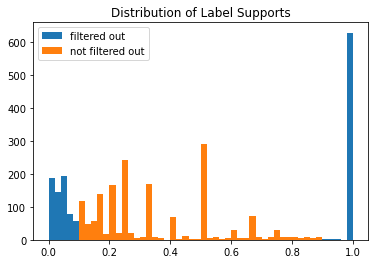

In [95]:
supports_file = "{}/candidate_labels_ail_quantity_supports.tsv".format(output_dir)
filtered_out_file = "{}/candidate_labels_ail_quantity_filtered_out.tsv".format(output_dir)
filtered_file = "{}/candidate_labels_ail_quantity_filtered.tsv".format(output_dir)
filter_by_support_and_plot(supports_file, filtered_out_file, filtered_file)